### GLM-eb 
J. Carpenter and B. Dunn \
November 2021

#### setup:

In [1]:
# preamble
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import scipy.sparse as sps
import scipy.stats as stats
from pyglmnet import GLM, simulate_glm
import scipy as sp
import statistics

In [2]:
# visualization parameters
plt.rcParams['figure.figsize'] = (10,4)
plt.rc('axes', labelsize=12); plt.rc('axes', titlesize=14)
plt.style.use('ggplot'); plt.rc('font', size=14);

In [3]:
# load & format data
filepath = 'sampleData.mat'
mat = scipy.io.loadmat(filepath)
ST = mat['ST']; P = mat['P']; hd = mat['hd']

#### define methods:

In [4]:
class glm:
    def __init__(self, ST, P, hd):
        self.ST = ST
        self.P = P
        self.x = P[:,1]
        self.y = P[:,2]
        self.t = P[:,0]
        self.hd = (hd[:,0]*np.pi)/180; # 0-2pi
        self.dt = np.round(statistics.mode(np.diff(P[:,0])),2);
        
    def get_size(self):
        '''get size of recording box'''
        boxsz = np.max([np.max(self.x), np.max(self.y)]);
        return boxsz
    
    def pos_map(self, nbins=10):
        '''design matrix for position variables'''
        boxsz = self.get_size()
        bins = np.arange(boxsz/nbins/2, boxsz-boxsz/nbins/2, boxsz/nbins)
        posgrid = np.zeros((len(self.x), nbins**2))
        for idx,val in enumerate(self.x):
            xvec = np.abs(self.x[idx]-bins); yvec = np.abs(self.y[idx]-bins);
            min_x = np.min(xvec)
            min_y = np.min(yvec)
            idx_x = np.where(xvec == min_x); idx_x = idx_x[0][0];
            idx_y = np.where(yvec == min_y); idx_y = idx_y[0][0];
            bin_idx = np.ravel_multi_index((idx_y,idx_x), dims=(nbins,nbins), order='C') # a11=0, a12=1, a13=2;
            posgrid[idx, bin_idx] = 1;
        return posgrid, bins
    
    def eb_map(self, nbins=10, rp=[75,75]):
        '''design matrix for egocentric variables'''
        refx = rp[0]; refy = rp[1];
        allo = np.arctan2(refy-self.y, refx-self.x) + (np.pi/2); # add 90 deg
        allo[allo<0] = allo[allo<0]+2*np.pi;
        ego = allo - self.hd; # shift from 0-2pi
        egogrid = np.zeros((len(P),nbins));
        bins = np.arange(2*np.pi/nbins/2, 2*np.pi-2*np.pi/nbins/2, 2*np.pi/nbins) # 10 bin ctrs
        for idx,val in enumerate(P):
            evec = np.abs(ego[idx]-bins)
            min_e = np.min(evec)
            idx_e = np.where(evec == min_e)
            egogrid[idx, idx_e] = 1;
        return egogrid, bins
    
    def conv_spktrain(self):
        '''get smoothed spiketrain from spiketimes'''
        # filter the spiketrain
        t = self.P[:,0];
        boolean_spk = np.logical_and(t[0] <= self.ST, self.ST <= t[-1])
        spikes = self.ST[boolean_spk == True]
        edgesT = np.linspace(t[0], t[-1], len(t)+1)
        binnedSpikes, timeEdges = np.histogram(spikes, edgesT)
        # convolve w/ gaussian membership fn
        Xx = np.linspace(-4,4,9); sigma = 2; c = 0;
        filt = np.exp((-(Xx-c)**2)/(2*(sigma**2)))
        dt = self.P[1,0]-self.P[0,0];
        fr = binnedSpikes/dt # rate (hz)
        smooth_fr = np.convolve(binnedSpikes, filt, mode='full')
        return smooth_fr, binnedSpikes, filt, dt
    
    def get_speed(self):
        '''get speed of the animal (cm*s^-2)'''
        t=self.P[:,0]; x=self.P[:,1]; y=self.P[:,2];
        ntime = len(t); v = np.zeros((ntime,1));
        for idx in range(1,ntime-1):
            v[idx,0] = np.sqrt((x[idx+1]-x[idx-1])**2 + (y[idx+1]-y[idx-1])**2)/(t[idx+1]-t[idx-1])    
        v[0,0] = v[1,0]; v[-1,0] = v[-2,0] # pad the array
        return v
    
    def speed_threshold(self,posgrid,ebgrid,spiketrain):
        v = self.get_speed()
        maxspeed=50; minspeed=4
        inbounds = np.logical_and((v<=maxspeed), (v>=minspeed))
        inbounds = np.where(inbounds==True); inbounds = inbounds[0]
        posgrid = posgrid[inbounds,:]
        ebgrid = ebgrid[inbounds,:]
        spiketrain = spiketrain[inbounds]
        return posgrid, ebgrid, spiketrain
    
    def squish_statemat(self, stateIn, modelType='PE'):
        '''squish state matrix for 2-variable model (P+EB)'''
        if modelType == 'PE':
            posgrid = stateIn[0]; ebgrid = stateIn[1]
            ntime,nbins_eb = np.shape(ebgrid)
            _,nbins_p = np.shape(posgrid)
            A = np.zeros((ntime, nbins_p+nbins_eb)) #P+EB
            A[:,0:nbins_p] = posgrid; A[:,nbins_p:] = ebgrid
            df=pd.DataFrame(A)
            mask = np.random.rand(len(df)) < 0.8
            df_train = df[mask]; df_test = df[~mask]
            # name columns & get expression
            colnames = [];
            expr = 'y ~ '
            for i in range(nbins_p):
                val = str(i);
                expr = expr + 'P' + val + ' + '
                colnames.append('P' + val)
            for i in range(nbins_eb-1):
                val = str(i);
                expr = expr + 'E' + val + ' + '
                colnames.append('E' + val)
            expr = expr + 'E9'
            colnames.append('E9')
            df.columns = colnames
        elif modelType == 'P':
            ntime,nbins = np.shape(stateIn)
            df = pd.DataFrame(stateIn)
            mask = np.random.rand(len(df)) < 0.8
            df_train = df[mask]; df_test = df[~mask]
            colnames = [];
            expr = 'y ~ '
            for i in range(nbins-1):
                val = str(i);
                expr = expr + 'P' + val + ' + '
                colnames.append('P' + val)
            expr = expr + 'P99'
            colnames.append('P99')
            df.columns = colnames
        elif modelType == 'E':
            ntime,nbins = np.shape(stateIn)
            df = pd.DataFrame(stateIn)
            mask = np.random.rand(len(df)) < 0.8
            df_train = df[mask]; df_test = df[~mask]
            colnames = [];
            expr = 'y ~ '
            for i in range(nbins-1):
                val = str(i);
                expr = expr + 'E' + val + ' + '
                colnames.append('E' + val)
            expr = expr + 'E9'
            colnames.append('E9')
            df.columns = colnames
        else:
            print('Error: model type must be "P", "E", or "PE"')
        return df,expr
    
    def kfoldSplit(self,df,spiketrain,nfolds):
        '''train-test split for k-fold xval'''
        # for a 20-min session (~2 chunks/sess)
        kfoldIdx = {}
        howLong = np.zeros(nfolds)
        edges = np.round(np.linspace(1,len(spiketrain)+1,nsections+1))
        for k in range(nfolds):
            test_ind = np.floor(np.linspace(int(edges[k]),
                    (int(edges[k+1])-1),
                    (int(edges[k+1])-1)-int(edges[k])))
            for s in range(1,nchunks):
                ind = np.floor(np.linspace(int(edges[k+s*nfolds]),
                                  (int(edges[k+s*nfolds+1])-1),
                                  (int(edges[k+s*nfolds+1]))-int(edges[k+s*nfolds])))
                np.append(test_ind,ind)
            kfoldIdx[k] = test_ind
            howLong[k] = len(test_ind); del test_ind;
        # adjust array length (within 0.02 s)
        minArrLen = int(np.min(howLong));
        for k in range(nfolds):
            kfoldIdx[k] = kfoldIdx[k][0:minArrLen]
        kfoldIdx_df = pd.DataFrame.from_dict(kfoldIdx)
        kfoldIdx_df = df.astype(int) # for idxing purposes
    
    ####################### DEPRECIATE #######################
    def test_train(self,df,expr,spiketrain):
        df.insert(loc=0, column='y', value=spiketrain, allow_duplicates=False)
        mask = np.random.rand(len(df)) < 0.8
        df_train = df[mask]
        df_test = df[~mask]
        # split into test and train, and booty
        y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
        y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
#         print('Training data set length='+str(len(df_train)))
#         print('Testing data set length='+str(len(df_test)))
        return y_train, X_train, y_test, X_test
    
    def test_train_arr(self,df,expr,spiketrain):
        '''return training set as array (not df)'''
        y_train, X_train, y_test, X_test = self.test_train(df,expr,spiketrain)
        y_train_arr = y_train.to_numpy(); y_test_arr = y_test.to_numpy()
        X_test_arr = X_test.to_numpy(); X_train_arr = X_train.to_numpy()
        X_train_arr = X_train_arr[:,1:];  X_test_arr = X_test_arr[:,1:]
        return y_train_arr, X_train_arr, y_test_arr, X_test_arr
    
    ####################### DEPRECIATE #######################
    
    def init_params(self,whichVars={'P', 'E'}):
        if whichVars == {'P', 'E'}: init_param = 1e-3*np.random.randn(110, 1);
        if whichVars == {'P'}: init_param = 1e-3*np.random.randn(100, 1);
        if whichVars == {'E'}: init_param = 1e-3*np.random.randn(10, 1);
        return init_param
    
    def getDataParam(self,x,y,w,b):
        '''put param & data in a dictionary'''
        param = np.append(b,w)
        data =  (x, y)
        return data,param
    
    def get_rate(self,x,w,b):
        '''conditional intensity function'''
        y_hat = np.exp(x @ w + b)
        return y_hat
    
    def loss(self,param,x,y):
        '''objective function'''
        y_hat = np.exp(x @ param[1:] + param[0])
        error = (y_hat - np.log(y_hat) * y).mean() #negative log likelihood for possom where yhat is lambda 
        
        #der= deriv
        return error
    
    def grad(self,x, y, w, b):
        '''compute the gradient of the loss fn'''
        M, n = x.shape
        y_hat = np.exp(x @ w + b)
        dw = (x.T @ (y_hat - y)) / M
        db = (y_hat - y).mean() # this we dont really need if the bias term is included as a column of 1's
        return dw, db

    def gradient_descent(self,x, y, w_0, b_0, alpha, num_iter):
        '''minimize loss function w/ gradient descent'''
        w, b = w_0.copy(), b_0
        hist = np.zeros(num_iter)
        M, n = x.shape
        for iter in range(num_iter):
            dw, db = self.grad(x, y, w, b)
            w -= alpha * dw
            b -= alpha * db
            hist[iter] = self.loss(x, y, w, b)
        return w, b, hist
    
    def bfgs(self,data,param):
        'minimize loss function w/ L-BFGS-B'
        res = sp.optimize.minimize(self.loss, x0=param, args=data, method='L-BFGS-B',  options={'gtol': 1e-6, 'disp': True})
        return res
    
    def get_stats(self, y, y_hat):
        # compare between test fr and model fr
        sse = np.sum((y_hat-y)**2);
        sst = sum((y-np.mean(y))**2);
        varExplain_test = 1-(sse/sst)
        r, pval_r = stats.pearsonr(y,y_hat)
#         print('sse: ' + str(sse))
#         print('sst: ' + str(sst))
#         print('varExplain_test: ' + str(varExplain_test))
#         print('R: ' + str(r) + ', p=' + str(pval_r))
        return sse, sst, varExplain_test, r, pval_r

#### prepare for battle:

In [5]:
# initialize class instance
g = glm(ST,P,hd)

# prepare the data
posgrid_raw,bins = g.pos_map(nbins=10)
ebgrid_raw,bins = g.eb_map(nbins=10, rp=[75,75])
smooth_fr, raw_spktrn, filt, dt = g.conv_spktrain()
posgrid,ebgrid,spiketrain = g.speed_threshold(posgrid_raw,ebgrid_raw,smooth_fr)

In [14]:
#train-test split scratch code
nfolds = 10
nmins = (len(spiketrain)*dt)/60
nchunks = int(round(nmins/nfolds))
nsections = int(nchunks*nfolds)

In [125]:
kfoldIdx = {}
howLong = np.zeros(nfolds)
edges = np.round(np.linspace(1,len(spiketrain)+1,nsections+1))
for k in range(nfolds):
    test_ind = np.floor(np.linspace(int(edges[k]),
            (int(edges[k+1])-1),
            (int(edges[k+1])-1)-int(edges[k])))
    for s in range(1,nchunks):
        ind = np.floor(np.linspace(int(edges[k+s*nfolds]),
                          (int(edges[k+s*nfolds+1])-1),
                          (int(edges[k+s*nfolds+1]))-int(edges[k+s*nfolds])))
        np.append(test_ind,ind)
    kfoldIdx[k] = test_ind
    howLong[k] = len(test_ind); del test_ind;
# adjust array length (within 0.02 s)
minArrLen = int(np.min(howLong));
for k in range(nfolds):
    kfoldIdx[k] = kfoldIdx[k][0:minArrLen]
kfoldIdx_df = pd.DataFrame.from_dict(kfoldIdx)
kfoldIdx_df = df.astype(int) # for idxing purposes

In [126]:
stateIn = [posgrid,ebgrid]
df, expr = g.squish_statemat(stateIn, modelType='PE')
# split data into test/train
y_train, X_train, y_test, X_test = g.test_train_arr(df,expr,spiketrain)
# get initial parameters (beta0 and beta_i's)
X = X_train; y = y_train;
y = np.squeeze(y)
M,n = np.shape(X)
w_0 = 1e-3*np.ones((n, )) # initial params
b_0 = 1
alpha = 0.001
data,param = g.getDataParam(X,y,w_0,b_0);

In [7]:
# initialize stats matrices 
nmodels = 3
sse = np.zeros((nmodels,1))
sst = np.zeros((nmodels,1))
varExplain_test = np.zeros((nmodels,1))
r = np.zeros((nmodels,1))
pval_r = np.zeros((nmodels,1))

#### visualize data:

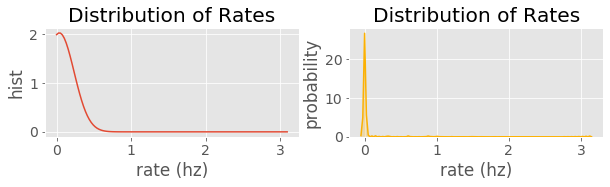

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
_, bin_edges = np.histogram(y,120)
ax[0].plot(bin_edges, scipy.stats.norm.pdf(bin_edges, loc=y.mean(), scale=y.std()))
ax[0].set_title(r'Distribution of Rates')
ax[0].set_xlabel('rate (hz)')
ax[0].set_ylabel('hist')

sns.kdeplot(y, color='#fcb103', bw=.017,shade=True)
ax[1].set_title(r'Distribution of Rates')
ax[1].set_xlabel('rate (hz)')
ax[1].set_ylabel('probability');

#### 1. PE model:

In [9]:
res = g.bfgs(data,param)
fr_hat_test = g.get_rate(X,res.x[1:],res.x[0])
smooth_fr_hat_test = np.convolve(fr_hat_test, filt, mode='same')
sse[0], sst[0], varExplain_test[0], r[0], pval_r[0] = g.get_stats(y, smooth_fr_hat_test)

#### 2. P model:

In [30]:
df_p, expr_p = g.squish_statemat(posgrid, modelType='P')
# split data into test/train
y_train_p, X_train_p, y_test_p, X_test_p = g.test_train_arr(df_p,expr_p,spiketrain)
# get initial parameters (beta0 and beta_i's)
X = X_train_p; y = y_train_p;
y = np.squeeze(y)
M,n = np.shape(X)
w_0 = 1e-3*np.ones((n, )) # initial params
b_0 = 1
alpha = 0.001
data,param = g.getDataParam(X,y,w_0,b_0);
res_p = g.bfgs(data,param)
y_hat_p = g.get_rate(X,res_p.x[1:],res_p.x[0])
smooth_y_hat_p = np.convolve(y_hat_p, filt, mode='same')
sse[1], sst[1], varExplain_test[1], r[1], pval_r[1] = g.get_stats(y, smooth_y_hat_p)

#### 3. E model:

In [ ]:
df_e, expr_e = g.squish_statemat(ebgrid, modelType='E')
# split data into test/train
y_train_e, X_train_e, y_test_e, X_test_e = g.test_train_arr(df_e,expr_e,spiketrain)
# get initial parameters (beta0 and beta_i's)
X = X_train_e; y = y_train_e;
y = np.squeeze(y)
M,n = np.shape(X)
w_0 = 1e-3*np.ones((n, )) # initial params
b_0 = 1
alpha = 0.001
data,param = g.getDataParam(X,y,w_0,b_0);
res_e = g.bfgs(data,param)
y_hat_e = g.get_rate(X,res_e.x[1:],res_e.x[0])
smooth_y_hat_e = np.convolve(y_hat_e, filt, mode='same')
sse[2], sst[2], varExplain_test[2], r[2], pval_r[2] = g.get_stats(y, smooth_y_hat_e)

#### visualize results:

In [ ]:
plt.bar(['PE', 'P', 'E'], sse);

In [ ]:
w_fit = res.x[1:]
b_fit = res.x[0]
y_hat = g.get_rate(X,w_fit,b_fit)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(y[0:10000], label='data');
ax.plot(smooth_fr_hat_test[0:10000],label='model');
ax.set_title(r'model vs. data')
ax.set_xlabel('time (s)')
ax.set_ylabel('rate (hz)');
ax.legend(loc="upper right");

#### Cross-validation stuff

In [31]:
# each section should be 1 minute in length
numFolds = 10
sections = numFolds*5;
bins_1min= int(60/g.dt);
nbins = round(len(g.x)/bins_1min);

_,numCol = np.shape(X);
testFit = np.zeros((numFolds,6)) # columns: var ex, correlation, llh increase, mse, # of spikes, length of test data
trainFit = np.zeros((numFolds,6)) #butts
paramMat = np.zeros((numFolds,numCol))

edges = np.round(np.linspace(1,len(spiketrain)+1,nbins+1));

In [32]:
nbins

22